## Imports

In [24]:
import pandas as pd
from collections import Counter
import seaborn as sns
import numpy 
import scipy

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer,f1_score
from sklearn.linear_model import LogisticRegression
from sys import getsizeof

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import f1_score

In [5]:
from sklearn.model_selection import train_test_split
from rfpimp import *

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


In [6]:
scorer = make_scorer(f1_score, needs_proba=False,
                     greater_is_better=True,average='micro')

## Functions and Class creations

In [10]:
def give_sub_file(preds, ids, path='../output/preds.csv'):
    '''Input the predictions with ids. Output the csv submission file'''
    preds = pd.DataFrame(preds,columns=['damage_grade'])
    preds['building_id'] = ids
    preds = preds[['building_id', 'damage_grade']]
    print(preds.columns)
    print(preds.shape)
    preds.to_csv(path, index=False)


Data processing functions
---

In [15]:
def create_X(df):
    X = df.copy()
    cat_cols = X.columns[X.dtypes == 'object']
    num_cols = [i for i in X.columns if i not in cat_cols]
    
    x1 = X[cat_cols].apply(LabelEncoder().fit_transform)
    X = pd.concat([X[num_cols], x1], axis=1)
    
    return X

def _new_ids(l1, l2):
    '''
    l1 and l2 are np.arrays
    l1 = train array
    l2 = test array
    '''
    
    if not isinstance(l1, np.ndarray):
        l1 = np.array(l1)
    if not isinstance(l2, np.ndarray):
        l2 = np.array(l2)
    
    mode = scipy.stats.mode(l1)[0][0]  # mode value of train
    
    bool_arr = np.array([i in l1 for i in l2])
    out = l2.copy()
    out[~bool_arr] = mode
    
    
    return out

def replace_new_ids(train_df, test_df, cols):
    '''
    train_df = train_df
    test_df = test_df
    cols = list of columns which have new ids not in train_df
    
    This function will replace any new values in the cols of 
    test_df with the mode of trains_df
    '''
    for column in cols:
        test_df.loc[:,column] = _new_ids(train_df.loc[:,column], test_df.loc[:,column])
    return train_df, test_df
    
    
def geo23_in_geo1(X_train, X_test):
    ''' Requirement: No new geo_level_2 ids in X_test'''
    
    dic_1_2 = dict(X_train.groupby('geo_level_1_id', as_index=False)['geo_level_2_id'].nunique())
    dic_1_3 = dict(X_train.groupby('geo_level_1_id', as_index=False)['geo_level_3_id'].nunique())
    
    for frame in [X_train, X_test]:
        frame['count12'] = frame.loc[:, 'geo_level_1_id'].apply(lambda x: dic_1_2[x])
        frame['count13'] = frame.loc[:, 'geo_level_1_id'].apply(lambda x: dic_1_3[x])
    
    return X_train, X_test
    

def new_rows(l1, l2):
    '''check how columns compare and how many differ'''
    s = set(l2) - set(l1)
    return len([i for i in l2 if i in s])

In [16]:
class FreqEncode:
    def __init__(self):
        self.freq_dict = {}
    
    def create_dict(self,train_col):
        return dict(train_col.value_counts())
    
    def fit(self, X_train, cols):
        '''
        X_train = train_df
        cols for which we need to encode frequency
        '''
        self.cols = cols
        for i in cols:
            value = self.create_dict(X_train[i])
            self.freq_dict[i] = value
    
    def transform(self, X_test):
        '''this appends freq encoding columns to X_test inplace'''
        for i in self.cols:
            X_test[i.strip()+'_fq'] = X_test[i].apply(lambda x: self.freq_dict[i][x])
        return X_test
    

## Data Import

In [17]:
#data is already very clean
df = pd.read_csv('../input/train_values.csv')
train_target = pd.read_csv('../input/train_labels.csv')
y = train_target.damage_grade

## Model Building

In [18]:
Counter(train_target.damage_grade)

Counter({3: 87218, 2: 148259, 1: 25124})

Baseline model using Mode of 2
---

In [19]:
y_true =  train_target.damage_grade
y_pred = [2]*len(y_true)

In [20]:
f1_score(y_true, y_pred, average='micro')

0.5689118614280068

Pipeline
---

In [32]:
pipe_lr = Pipeline([('scl', StandardScaler()),          # Transformer: Standardize
                    ('clf', LogisticRegression(solver='lbfgs', # Estimator: ML algorithm
                                               multi_class='multinomial'))])

In [33]:
pipe_rf = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', RandomForestClassifier ())])

In [34]:
pipelines = [pipe_lr, pipe_rf]

In [38]:
# Fit the pipelines 
X_train, X_test, y_train, y_test = train_test_split(create_X(df), y, test_size=0.2, random_state=42)
for pipe in pipelines:
    pipe.fit(X_train, y_train) # One-liners fits all models 
# Compare accuracies
for pipe in pipelines:
    name = pipe.steps[-1][1].__class__.__name__.split('.')[-1] # Fluent like a boss
    print(f"{name:<22}: {pipe.score(X_test, y_test):.2%}")

/Users/rushilsheth/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


LogisticRegression    : 58.09%
RandomForestClassifier: 52.78%


Random Forests
---

In [21]:
X = create_X(df)

In [22]:
X, _ = geo23_in_geo1(X,X)

In [25]:
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

X, _ = replace_new_ids(X, X, geo_features)


In [26]:
fe = FreqEncode()
fe.fit(X,geo_features)
X = fe.transform(X)

In [27]:
model = RandomForestClassifier(n_estimators=200, min_samples_leaf=3, n_jobs=-1)

In [28]:
cross_val_score(estimator=model,X = X, y=y, scoring=scorer, cv=3,n_jobs=-1)

array([0.74176912, 0.74227564, 0.74112704])

In [29]:
model.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

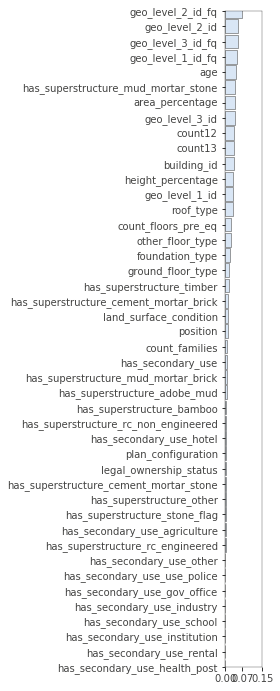

In [30]:
#check feat importance and fit model only using top 20
imp = importances(model, X, y) # permutation
viz = plot_importances(imp)
top20 = imp.iloc[:20].index.tolist()

In [ ]:
cross_val_score(estimator=model,X = X[top20], y=y, scoring=scorer, cv=3,n_jobs=-1)